## Importing libraries

In [2]:
import networkx as nx
import pandas as pd
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import powerlaw

#### the list of all airlines (open source dataset)

In [809]:
airports_ext = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/OpenFlights/airports.csv')
airports_ext = airports_ext.iloc[:,:9]
airports_ext.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146


#### the list of all airports (open source dataset)

In [810]:
from FlightRadar24.api import FlightRadar24API
fr_api = FlightRadar24API()


In [811]:
airports = fr_api.get_airports()

In [812]:
airports = pd.DataFrame(airports)
airports.head()

,name,iata,icao,lat,lon,country,alt
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1


In [813]:
airports = airports.dropna()

In [814]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5042 entries, 0 to 5041
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     5042 non-null   object 
 1   iata     5042 non-null   object 
 2   icao     5042 non-null   object 
 3   lat      5042 non-null   float64
 4   lon      5042 non-null   float64
 5   country  5042 non-null   object 
 6   alt      5042 non-null   object 
dtypes: float64(2), object(5)
memory usage: 275.9+ KB


#### Europe airports

In [815]:
lat_min = 34.3
lat_max = 71.3
long_min = -25.3
long_max = 50.0


# Filter the DataFrame to only include locations within the boundaries
airports_eur = airports[(airports['lat'] >= lat_min) & (airports['lat'] <= lat_max) &
        (airports['lon'] >= long_min) & (airports['lon'] <= long_max)]

In [816]:
# List of countries to remove
countries_to_remove = ['Libya', 'Syria','Algeria','Tunisia','Morocco','Egypt','Iran','Iraq']

# Create a Boolean mask that identifies the rows to be removed
mask = airports_eur['country'].isin(countries_to_remove)

# Drop the rows identified by the Boolean mask
airports_eur = airports_eur[~mask]



In [817]:
import folium

# Define the center point for the map
center_lat = (lat_min + lat_max) / 2
center_long = (long_min + long_max) / 2

# Create a map centered on the defined center point
m = folium.Map(location=[center_lat, center_long], zoom_start=3)

# Add a rectangle to the map to represent the boundaries
folium.Rectangle(
    bounds = [[lat_min, long_min], [lat_max, long_max]],
    color='blue',
    fill= False
).add_to(m)

# Add markers for each airport in the DataFrame
for index, row in airports_eur.iterrows():
   if lat_min <= row['lat'] <= lat_max and long_min <= row['lon'] <= long_max:
        radius = 2  # Change the radius to adjust the size of the dots
        color = 'blue'  # Change the color of the dots
        fill_color = 'blue'  # Change the fill color of the dots
        fill_opacity = 0.2  # Change the fill opacity of the dots
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            color=color,
            fill_color=fill_color,
            fill_opacity=fill_opacity,
            tooltip=row['name']
        ).add_to(m)

# Show the map
m

In [818]:
airports_eur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 5040
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     986 non-null    object 
 1   iata     986 non-null    object 
 2   icao     986 non-null    object 
 3   lat      986 non-null    float64
 4   lon      986 non-null    float64
 5   country  986 non-null    object 
 6   alt      986 non-null    object 
dtypes: float64(2), object(5)
memory usage: 61.6+ KB


# THE CODE FOR OBTAINING SCHEDULES

In [ ]:
#getting data for european airports (before war)

In [819]:
import pandas as pd
from tqdm import tqdm
import requests
import json


# Replace [API_KEY] with your own API key
API_KEY = '[API_KEY]'

# Define the start and end dates
start_date = '2023-01-21'
end_date = '2023-01-28'

airport_codes= list(airports_eur['iata'].unique())

# Initialize an empty list to store the API responses
responses = []

# Loop over the list of airport codes
for airport in tqdm(airport_codes, desc='Getting timetable'):
    # Make a GET request to the API
    url = f'https://aviation-edge.com/v2/public/flightsHistory?key={API_KEY}&code={airport}&type=departure&date_from={start_date}&date_to={end_date}'
    response = requests.get(url,timeout=30)
    
    # Add the API response to the list
    try:
        responses.append(response.json())
    except json.JSONDecodeError as e:
        print(f'Error decoding JSON response for {airport}: {e}')

Getting timetable: 100%|██████████████████████| 986/986 [11:56<00:00,  1.38it/s]


In [820]:
df_list = []
for sublist in responses:
    try:
        df_list.append(pd.DataFrame(sublist))
    except ValueError as e:
        print("Error while converting JSON to dataframe:", e)

df = pd.concat(df_list)

Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, 

In [821]:
#df= df.drop(columns ='codeshared')
df = df.reset_index(drop=True)
df.head()

,type,status,departure,arrival,airline,flight,codeshared
0,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'american airlines', 'iataCode': 'aa'...","{'number': '8546', 'iataNumber': 'aa8546', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib..."
1,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6197', 'iataNumber': 'av6197', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib..."
2,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'finnair', 'iataCode': 'ay', 'icaoCod...","{'number': '5606', 'iataNumber': 'ay5606', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib..."
3,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'british airways', 'iataCode': 'ba', ...","{'number': '7111', 'iataNumber': 'ba7111', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib..."
4,departure,active,"{'iataCode': 'lcg', 'icaoCode': 'leco', 'termi...","{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'cathay pacific', 'iataCode': 'cx', '...","{'number': '1862', 'iataNumber': 'cx1862', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib..."


In [822]:
df = df.drop(columns = ['type'])

In [823]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235787 entries, 0 to 235786
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   status      235787 non-null  object
 1   departure   235787 non-null  object
 2   arrival     235787 non-null  object
 3   airline     235787 non-null  object
 4   flight      235787 non-null  object
 5   codeshared  111852 non-null  object
dtypes: object(6)
memory usage: 10.8+ MB


In [824]:
# Use pandas.json_normalize() to extract the values from the dictionaries
departures = pd.json_normalize(df['departure'])

# Rename the columns to include 'departure' and the dictionary key
departures.columns = ['departure_' + col for col in departures.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([df, departures], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('departure', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_icaoCode,departure_terminal,departure_gate,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_estimatedRunway,departure_actualRunway,departure_delay
0,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'american airlines', 'iataCode': 'aa'...","{'number': '8546', 'iataNumber': 'aa8546', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,leco,t1,3,2023-01-21t06:30:00.000,2023-01-21t06:30:00.000,NaN,NaN,NaN,NaN
1,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6197', 'iataNumber': 'av6197', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,leco,t1,3,2023-01-21t06:30:00.000,2023-01-21t06:30:00.000,NaN,NaN,NaN,NaN
2,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'finnair', 'iataCode': 'ay', 'icaoCod...","{'number': '5606', 'iataNumber': 'ay5606', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,leco,t1,3,2023-01-21t06:30:00.000,2023-01-21t06:30:00.000,NaN,NaN,NaN,NaN
3,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'british airways', 'iataCode': 'ba', ...","{'number': '7111', 'iataNumber': 'ba7111', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,leco,t1,3,2023-01-21t06:30:00.000,2023-01-21t06:30:00.000,NaN,NaN,NaN,NaN
4,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'cathay pacific', 'iataCode': 'cx', '...","{'number': '1862', 'iataNumber': 'cx1862', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,leco,t1,3,2023-01-21t06:30:00.000,2023-01-21t06:30:00.000,NaN,NaN,NaN,NaN


In [825]:
ndf = ndf.drop(columns = ['departure_icaoCode','departure_actualTime', 'departure_estimatedRunway' , 'departure_actualRunway', 'departure_terminal' , 'departure_gate', 'departure_estimatedTime'])
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay
0,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'american airlines', 'iataCode': 'aa'...","{'number': '8546', 'iataNumber': 'aa8546', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN
1,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6197', 'iataNumber': 'av6197', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN
2,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'finnair', 'iataCode': 'ay', 'icaoCod...","{'number': '5606', 'iataNumber': 'ay5606', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN
3,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'british airways', 'iataCode': 'ba', ...","{'number': '7111', 'iataNumber': 'ba7111', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN
4,active,"{'iataCode': 'mad', 'icaoCode': 'lemd', 'termi...","{'name': 'cathay pacific', 'iataCode': 'cx', '...","{'number': '1862', 'iataNumber': 'cx1862', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN


In [826]:
# Use pandas.json_normalize() to extract the values from the dictionaries
arrivals = pd.json_normalize(ndf['arrival'])

# Rename the columns to include 'arrival' and the dictionary key
arrivals.columns = ['arrival_' + col for col in arrivals.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, arrivals], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('arrival', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_icaoCode,arrival_terminal,arrival_baggage,arrival_scheduledTime,arrival_estimatedTime,arrival_actualTime,arrival_estimatedRunway,arrival_actualRunway,arrival_delay,arrival_gate
0,active,"{'name': 'american airlines', 'iataCode': 'aa'...","{'number': '8546', 'iataNumber': 'aa8546', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,lemd,4,16,2023-01-21t07:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6197', 'iataNumber': 'av6197', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,lemd,4,16,2023-01-21t07:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN
2,active,"{'name': 'finnair', 'iataCode': 'ay', 'icaoCod...","{'number': '5606', 'iataNumber': 'ay5606', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,lemd,4,16,2023-01-21t07:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'name': 'british airways', 'iataCode': 'ba', ...","{'number': '7111', 'iataNumber': 'ba7111', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,lemd,4,16,2023-01-21t07:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'name': 'cathay pacific', 'iataCode': 'cx', '...","{'number': '1862', 'iataNumber': 'cx1862', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,lemd,4,16,2023-01-21t07:50:00.000,NaN,NaN,NaN,NaN,NaN,NaN


In [827]:
ndf = ndf.drop(columns = [ 'arrival_icaoCode' , 'arrival_terminal', 'arrival_baggage' ,'arrival_actualTime', 'arrival_estimatedTime', 'arrival_estimatedRunway','arrival_actualRunway','arrival_gate'])
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay
0,active,"{'name': 'american airlines', 'iataCode': 'aa'...","{'number': '8546', 'iataNumber': 'aa8546', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN
1,active,"{'name': 'sa avianca', 'iataCode': 'av', 'icao...","{'number': '6197', 'iataNumber': 'av6197', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN
2,active,"{'name': 'finnair', 'iataCode': 'ay', 'icaoCod...","{'number': '5606', 'iataNumber': 'ay5606', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN
3,active,"{'name': 'british airways', 'iataCode': 'ba', ...","{'number': '7111', 'iataNumber': 'ba7111', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN
4,active,"{'name': 'cathay pacific', 'iataCode': 'cx', '...","{'number': '1862', 'iataNumber': 'cx1862', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN


In [828]:
# Use pandas.json_normalize() to extract the values from the dictionaries
airlines = pd.json_normalize(ndf['airline'])

# Rename the columns to include 'airline' and the dictionary key
airlines.columns = ['airline_' + col for col in airlines.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, airlines], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('airline', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,flight,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,airline_icaoCode
0,active,"{'number': '8546', 'iataNumber': 'aa8546', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,american airlines,aa,aal
1,active,"{'number': '6197', 'iataNumber': 'av6197', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,sa avianca,av,ava
2,active,"{'number': '5606', 'iataNumber': 'ay5606', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,finnair,ay,fin
3,active,"{'number': '7111', 'iataNumber': 'ba7111', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,british airways,ba,baw
4,active,"{'number': '1862', 'iataNumber': 'cx1862', 'ic...","{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,cathay pacific,cx,cpa


In [829]:
ndf = ndf.drop(columns = [ 'airline_icaoCode'])


In [830]:
# Use pandas.json_normalize() to extract the values from the dictionaries
flights = pd.json_normalize(ndf['flight'])

# Rename the columns to include 'flight' and the dictionary key
flights.columns = ['flight_' + col for col in flights.columns]

# Concatenate the original DataFrame and the new flights DataFrame
ndf = pd.concat([ndf, flights], axis=1)

# Drop the original 'flights' column
ndf = ndf.drop('flight', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,flight_icaoNumber
0,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,american airlines,aa,8546,aa8546,aal8546
1,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,sa avianca,av,6197,av6197,ava6197
2,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,finnair,ay,5606,ay5606,fin5606
3,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,british airways,ba,7111,ba7111,baw7111
4,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,cathay pacific,cx,1862,cx1862,cpa1862


In [831]:
ndf = ndf.drop(columns = ['flight_icaoNumber'])
ndf.head()

,status,codeshared,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber
0,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,american airlines,aa,8546,aa8546
1,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,sa avianca,av,6197,av6197
2,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,finnair,ay,5606,ay5606
3,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,british airways,ba,7111,ba7111
4,active,"{'airline': {'name': 'iberia', 'iataCode': 'ib...",lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,cathay pacific,cx,1862,cx1862


In [832]:
# Use pandas.json_normalize() to extract the values from the dictionaries
codeshared = pd.json_normalize(ndf['codeshared'])

# Rename the columns to include 'codeshared' and the dictionary key
codeshared.columns = ['codeshared_' + col for col in codeshared.columns]

# Concatenate the original DataFrame and the new codeshared DataFrame
ndf = pd.concat([ndf, codeshared], axis=1)

# Drop the original 'codeshared' column
ndf = ndf.drop('codeshared', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_airline.iataCode,codeshared_airline.icaoCode,codeshared_flight.number,codeshared_flight.iataNumber,codeshared_flight.icaoNumber
0,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,american airlines,aa,8546,aa8546,iberia,ib,ibe,511,ib511,ibe511
1,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,sa avianca,av,6197,av6197,iberia,ib,ibe,511,ib511,ibe511
2,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,finnair,ay,5606,ay5606,iberia,ib,ibe,511,ib511,ibe511
3,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,british airways,ba,7111,ba7111,iberia,ib,ibe,511,ib511,ibe511
4,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,cathay pacific,cx,1862,cx1862,iberia,ib,ibe,511,ib511,ibe511


In [833]:
ndf = ndf.drop(columns = [ 'codeshared_airline.iataCode','codeshared_airline.icaoCode','codeshared_flight.number','codeshared_flight.icaoNumber'])
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,american airlines,aa,8546,aa8546,iberia,ib511
1,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,sa avianca,av,6197,av6197,iberia,ib511
2,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,finnair,ay,5606,ay5606,iberia,ib511
3,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,british airways,ba,7111,ba7111,iberia,ib511
4,active,lcg,2023-01-21t06:30:00.000,NaN,mad,2023-01-21t07:50:00.000,NaN,cathay pacific,cx,1862,cx1862,iberia,ib511


In [834]:
ndf.loc[ndf['codeshared_airline.name'].isnull(), 'codeshared_airline.name'] = ndf.loc[ndf['codeshared_airline.name'].isnull(), 'airline_name']
ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'codeshared_flight.iataNumber'] = ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'flight_iataNumber']
ndf['departure_delay'].fillna(0, inplace=True)


In [835]:
ndf.loc[ndf['arrival_delay'].isnull(), 'arrival_delay'] = ndf.loc[ndf['arrival_delay'].isnull(), 'departure_delay']
ndf[['departure_iataCode', 'arrival_iataCode']] = ndf[['departure_iataCode', 'arrival_iataCode']].applymap(str.upper)

In [836]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235787 entries, 0 to 235786
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   status                        235787 non-null  object 
 1   departure_iataCode            235787 non-null  object 
 2   departure_scheduledTime       235787 non-null  object 
 3   departure_delay               235787 non-null  float64
 4   arrival_iataCode              235787 non-null  object 
 5   arrival_scheduledTime         235787 non-null  object 
 6   arrival_delay                 235787 non-null  float64
 7   airline_name                  235787 non-null  object 
 8   airline_iataCode              235787 non-null  object 
 9   flight_number                 235787 non-null  object 
 10  flight_iataNumber             235787 non-null  object 
 11  codeshared_airline.name       235787 non-null  object 
 12  codeshared_flight.iataNumber  235787 non-nul

In [837]:
ndf.head()

,status,departure_iataCode,departure_scheduledTime,departure_delay,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,LCG,2023-01-21t06:30:00.000,0.0,MAD,2023-01-21t07:50:00.000,0.0,american airlines,aa,8546,aa8546,iberia,ib511
1,active,LCG,2023-01-21t06:30:00.000,0.0,MAD,2023-01-21t07:50:00.000,0.0,sa avianca,av,6197,av6197,iberia,ib511
2,active,LCG,2023-01-21t06:30:00.000,0.0,MAD,2023-01-21t07:50:00.000,0.0,finnair,ay,5606,ay5606,iberia,ib511
3,active,LCG,2023-01-21t06:30:00.000,0.0,MAD,2023-01-21t07:50:00.000,0.0,british airways,ba,7111,ba7111,iberia,ib511
4,active,LCG,2023-01-21t06:30:00.000,0.0,MAD,2023-01-21t07:50:00.000,0.0,cathay pacific,cx,1862,cx1862,iberia,ib511


# ANALYSIS PART

In [3]:
ndf = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/codeshared/allflights23europe21012801.csv')

In [1086]:
#calculating the frequency of the flights

In [839]:
eur_g1 = ndf[ndf['flight_iataNumber'] == ndf['codeshared_flight.iataNumber']]

In [840]:
eur_g1 = eur_g1[eur_g1['status'] == 'active']

In [841]:
eur_g1 = eur_g1.drop_duplicates(subset=['departure_iataCode', 'departure_scheduledTime', 'arrival_iataCode'])

In [842]:
eur_g = eur_g1.drop(columns = ['status','departure_scheduledTime','departure_delay','flight_iataNumber','arrival_scheduledTime','arrival_delay','airline_iataCode','flight_number','codeshared_airline.name','codeshared_flight.iataNumber'])

In [843]:
eur_g = eur_g[eur_g['departure_iataCode'] != eur_g['arrival_iataCode']]


In [846]:
###------------

In [961]:
eur_g1=eur_g.drop(columns ='airline_name')

In [1087]:
df_grouped1 = eur_g1.groupby(eur_g1.columns.tolist()).size().reset_index(name='counts')

# Reset the index to remove the old index and create a new one
df_grouped1 = df_grouped1.reset_index(drop=True)
df_grouped1.sort_values('counts', ascending=False).head(10)

,departure_iataCode,arrival_iataCode,counts
9727,OSL,TRD,162
11844,TLS,ORY,161
9568,ORY,NCE,161
9094,NCE,ORY,161
9600,ORY,TLS,160
11933,TRD,OSL,159
7957,MAD,PMI,155
1032,BCN,PMI,152
9982,PMI,BCN,150
10012,PMI,MAD,141


In [1088]:
df_grouped1 =  df_grouped1.merge(airports_ext, left_on='departure_iataCode', right_on='IATA')

In [1089]:
df_grouped1 = df_grouped1.drop(columns=['ICAO','IATA'])
df_grouped1.head()

,departure_iataCode,arrival_iataCode,counts,Airport ID,Name,City,Country,Latitude,Longitude,Altitude
0,AAL,AGP,2,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
1,AAL,AMS,13,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
2,AAL,BLL,2,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
3,AAL,CPH,105,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10
4,AAL,FUE,1,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10


In [1090]:
df_grouped1.sort_values(by="counts",ascending= False).head(10)

,departure_iataCode,arrival_iataCode,counts,Airport ID,Name,City,Country,Latitude,Longitude,Altitude
9592,OSL,TRD,162,644,Oslo Lufthavn,Oslo,Norway,60.121000,11.050200,681
11709,TLS,ORY,161,1273,Toulouse-Blagnac Airport,Toulouse,France,43.629101,1.363820,499
8959,NCE,ORY,161,1354,Nice-Côte d'Azur Airport,Nice,France,43.658401,7.215870,12
9433,ORY,NCE,161,1386,Paris-Orly Airport,Paris,France,48.723333,2.379444,291
9465,ORY,TLS,160,1386,Paris-Orly Airport,Paris,France,48.723333,2.379444,291
11798,TRD,OSL,159,665,Trondheim Airport Værnes,Trondheim,Norway,63.457802,10.924000,56
7822,MAD,PMI,155,1229,Adolfo Suárez Madrid–Barajas Airport,Madrid,Spain,40.471926,-3.562640,1998
1032,BCN,PMI,152,1218,Barcelona International Airport,Barcelona,Spain,41.297100,2.078460,12
9847,PMI,BCN,150,3998,Palma De Mallorca Airport,Palma de Mallorca,Spain,39.551701,2.738810,27
1236,BGO,OSL,141,636,Bergen Airport Flesland,Bergen,Norway,60.293400,5.218140,170


In [1091]:
df_grouped1 =  df_grouped1.merge(airports_ext, left_on='arrival_iataCode', right_on='IATA')
df_grouped1.head()

,departure_iataCode,arrival_iataCode,counts,Airport ID_x,Name_x,City_x,Country_x,Latitude_x,Longitude_x,Altitude_x,Airport ID_y,Name_y,City_y,Country_y,IATA,ICAO,Latitude_y,Longitude_y,Altitude_y
0,AAL,AGP,2,628,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,10,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
1,AAR,AGP,3,607,Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,82,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
2,ALC,AGP,3,1212,Alicante International Airport,Alicante,Spain,38.282200,-0.558156,142,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
3,ANR,AGP,4,299,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280,39,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53
4,ARN,AGP,17,737,Stockholm-Arlanda Airport,Stockholm,Sweden,59.651901,17.918600,137,1230,Málaga Airport,Malaga,Spain,AGP,LEMG,36.6749,-4.49911,53


In [1092]:
df_grouped = eur_g.groupby(eur_g.columns.tolist()).size().reset_index(name='counts')

# Reset the index to remove the old index and create a new one
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.sort_values('counts', ascending=False).head(10)

,departure_iataCode,arrival_iataCode,airline_name,counts
17718,TLS,ORY,air france,134
14506,ORY,TLS,air france,129
6078,ESB,IST,turkish airlines,122
14451,ORY,NCE,air france,121
8670,IST,ESB,turkish airlines,121
13808,NCE,ORY,air france,120
17028,SVO,LED,aeroflot,119
10202,LED,SVO,aeroflot,116
150,ADB,IST,turkish airlines,112
8553,IST,AYT,turkish airlines,108


In [1094]:
dflights_j =  df_grouped.merge(airports_ext, left_on='departure_iataCode', right_on='IATA')

In [1095]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])

In [1096]:
dflights_j = dflights_j.loc[:,['Airport ID','departure_iataCode','arrival_iataCode','Name','City','Country','Latitude','Longitude','airline_name','counts']]
dflights_j = dflights_j.rename(columns={"City": "City_origin", "Latitude":"Latitude_origin", "Longitude": "Longitude_origin", 'Country':'Country_origin','Name':'Name_origin','departure':'code_origin','arrival':'code_dest'})

In [1097]:
dflights_j =  dflights_j.merge(airports_ext, left_on='arrival_iataCode', right_on='IATA')

In [1098]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])


In [1099]:
dflights_j = dflights_j.rename(columns={"City": "City_dest", "Latitude":"Latitude_dest", "Longitude": "Longitude_dest", 'Country':'Country_dest','Name':'Name_dest'})
dflights_j.head()


,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
0,628,AAL,AGP,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,norwegian air shuttle aoc,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
1,607,AAR,AGP,Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,ryanair,3,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
2,1212,ALC,AGP,Alicante International Airport,Alicante,Spain,38.282200,-0.558156,tuifly,3,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
3,299,ANR,AGP,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280,tuifly,4,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53
4,737,ARN,AGP,Stockholm-Arlanda Airport,Stockholm,Sweden,59.651901,17.918600,norwegian air shuttle aoc,8,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53


In [1100]:
dflights_j.to_csv('/Users/vladislavluksha/TESI DI LAUREA/flights_europe2023january.csv', index=False)

In [1226]:
error_df = dflights_j[dflights_j['departure_iataCode'].isin(dflights_j['arrival_iataCode'].unique()) & ~dflights_j['arrival_iataCode'].isin(dflights_j['departure_iataCode'].unique())]
error_df = error_df[error_df['arrival_iataCode'].isin(airports_eur['iata'])]

# Create a new dataframe for the return flights
return_flights_df = error_df.copy()

# Swap the values in the appropriate columns to create the return flights
return_flights_df.rename(columns={
    'Airport ID_x': 'Airport ID_y',
    'Airport ID_y': 'Airport ID_x',
    'departure_iataCode': 'arrival_iataCode',
    'arrival_iataCode' : 'departure_iataCode',
    'Name_origin': 'Name_dest',
    'Name_dest': 'Name_origin',
    'City_origin': 'City_dest',
    'City_dest': 'City_origin',
    'Country_origin': 'Country_dest',
    'Country_dest': 'Country_origin',
    'Latitude_origin': 'Latitude_dest',
    'Latitude_dest': 'Latitude_origin',
    'Longitude_origin': 'Longitude_dest',
    'Longitude_dest': 'Longitude_origin',
    
}, inplace=True)

# Concatenate the existing dataframe and the return flights dataframe
new_df = pd.concat([dflights_j, return_flights_df], ignore_index=True)

# Save the new dataframe to a file or use it for further analysis
new_df.to_csv('EUjanuary23.csv', index=False)

In [1227]:
new_df = new_df[~(((new_df['departure_iataCode'] == 'IWA') & (new_df['Country_dest'] != 'Russia')) | ((new_df['arrival_iataCode'] == 'IWA') & (new_df['Country_origin'] != 'Russia')))]

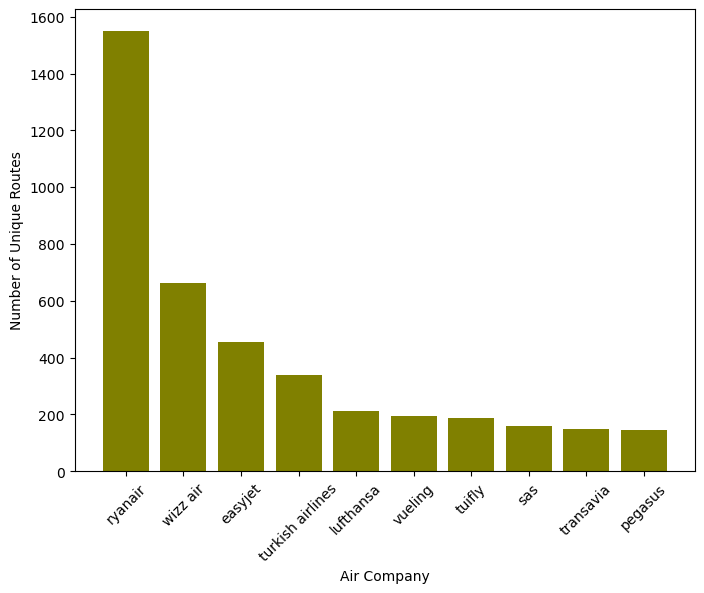

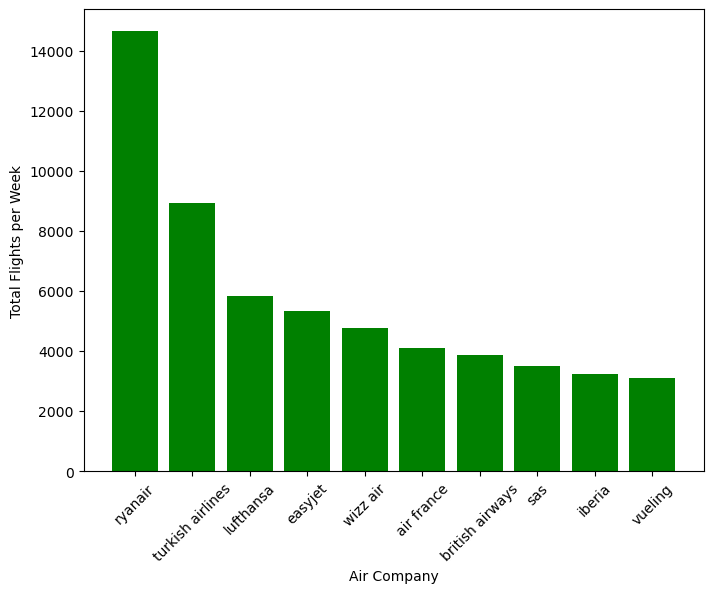

In [1313]:
# Group the data by airline and count the number of unique routes for each airline
route_counts = new_df.groupby('airline_name').apply(lambda x: len(x[['departure_iataCode', 'arrival_iataCode']]))
route_counts = route_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the number of unique routes for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(route_counts.index, route_counts.values/2, color=['olive'])
ax.set_xlabel('Air Company')
ax.set_ylabel('Number of Unique Routes')
plt.xticks(rotation=45)

# Group the data by airline and sum the number of flights for each airline
flight_counts = new_df.groupby('airline_name')['counts'].sum()
flight_counts = flight_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the total number of flights for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(flight_counts.index, flight_counts.values, color=['green'])
ax.set_xlabel('Air Company')
ax.set_ylabel('Total Flights per Week')
plt.xticks(rotation=45)

plt.show()

In [1104]:
new_df[new_df['departure_iataCode']=='IST']['airline_name'].unique()

array(['turkish airlines', 'klm', 'uls airlines cargo', 'iraero',
       'red wings', 'rossiya airlines', 's7 airlines', 'aeroflot',
       'tarom', 'mng airlines', 'fai rent-a-jet', 'british airways',
       'chrono jet', 'vistajet', 'pegasus', 'middle east airlines',
       'hyperion aviation', 'lufthansa', 'lufthansa cargo',
       'ata airlines', 'iran air', 'iran airtour', 'iran aseman airlines',
       'mahan air', 'qeshm airlines', 'taban airlines', 'flyadeal',
       'saudia', 'aegean airlines', 'air france', 'asl airlines ireland',
       'fedex', 'ups airlines', 'emirates', 'flydubai',
       'azal azerbaijan airlines', 'georgian airlines', 'silk way west',
       'jazeera airways', 'kuwait airways', 'lanmei airlines',
       'air serbia', 'just us air', 'somon air', 'bh air', 'fly one',
       'flyone armenia', 'azimuth', 'belavia', 'pegas fly',
       'uzbekistan airways', 'pobeda', 'corendon air', 'royal air maroc',
       'air arabia', 'freebird airlines', 'transavia',
  

In [1262]:
low_cost_companies = ['ryanair','ryanair sun','easyjet', 'wizz air', 'jet2', 'air baltic', 'vueling', 'pobeda', 'air arabia', 'norwegian', 'transavia','pegasus','lauda europe']
star_alliance = ['adria airways', 'aegean airlines', 'air canada', 'air china', 'air india', 'air new zealand', 'ana', 'asiana airlines', 'austrian airlines', 'avianca', 'brussels airlines', 'copa airlines', 'croatia airlines', 'egyptair', 'ethiopian airlines', 'eva air', 'lot - polish airlines', 'lufthansa', 'sas', 'shenzhen airlines', 'singapore airlines', 'south african airways', 'swiss', 'taiwan\'s eva air', 'tap air portugal', 'thai airways', 'turkish airlines', 'united airlines']
sky_team = ['aeroflot', 'aerolíneas argentinas', 'aeromexico', 'air europa', 'air france', 'ita airways', 'china airlines', 'china eastern airlines', 'china southern airlines', 'czech airlines', 'delta air lines', 'garuda indonesia', 'kenya airways', 'klm', 'korean air', 'middle east airlines', 'saudia', 'tarom', 'vietnam airlines', 'xiamen airlines']
one_world = ['american airlines', 'british airways', 'cathay pacific', 'finnair', 'iberia', 'japan airlines', 'latam airlines', 'malaysia airlines', 'qantas', 'qatar airways', 'royal jordanian', 's7 airlines', 'sri lankan airlines']
charter = ['tuifly', 'vistajet', 'sunexpress','red wings']

In [1106]:
new_df.sort_values(by="counts",ascending= False).head(10)

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
12002,1273,TLS,ORY,Toulouse-Blagnac Airport,Toulouse,France,43.629101,1.363820,air france,134,1386,Paris-Orly Airport,Paris,France,48.723333,2.379444,291
13730,1386,ORY,TLS,Paris-Orly Airport,Paris,France,48.723333,2.379444,air france,129,1273,Toulouse-Blagnac Airport,Toulouse,France,43.629101,1.363820,499
5547,1682,ESB,IST,Esenboğa International Airport,Ankara,Turkey,40.128101,32.995098,turkish airlines,122,13696,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,325
13574,1386,ORY,NCE,Paris-Orly Airport,Paris,France,48.723333,2.379444,air france,121,1354,Nice-Côte d'Azur Airport,Nice,France,43.658401,7.215870,12
5169,13696,IST,ESB,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,turkish airlines,121,1682,Esenboğa International Airport,Ankara,Turkey,40.128101,32.995098,3125
11978,1354,NCE,ORY,Nice-Côte d'Azur Airport,Nice,France,43.658401,7.215870,air france,120,1386,Paris-Orly Airport,Paris,France,48.723333,2.379444,291
1856,2985,SVO,LED,Sheremetyevo International Airport,Moscow,Russia,55.972599,37.414600,aeroflot,119,2948,Pulkovo Airport,St. Petersburg,Russia,59.800301,30.262501,78
8327,2948,LED,SVO,Pulkovo Airport,St. Petersburg,Russia,59.800301,30.262501,aeroflot,116,2985,Sheremetyevo International Airport,Moscow,Russia,55.972599,37.414600,622
5487,1706,ADB,IST,Adnan Menderes International Airport,Izmir,Turkey,38.292400,27.157000,turkish airlines,112,13696,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,325
5008,13696,IST,AYT,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,turkish airlines,108,1688,Antalya International Airport,Antalya,Turkey,36.898701,30.800501,177


In [1231]:
from math import radians, sin, cos, sqrt, atan2

In [1232]:
def distance(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['Latitude_origin'])
    lon1 = radians(row['Longitude_origin'])
    lat2 = radians(row['Latitude_dest'])
    lon2 = radians(row['Longitude_dest'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance


In [1233]:
new_df['distance'] = new_df.apply(distance, axis=1)

In [1234]:
new_df.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude,distance
0,628,AAL,AGP,Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,norwegian air shuttle aoc,2,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53,2507.629836
1,607,AAR,AGP,Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,ryanair,3,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53,2458.514145
2,1212,ALC,AGP,Alicante International Airport,Alicante,Spain,38.282200,-0.558156,tuifly,3,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53,391.068377
3,299,ANR,AGP,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280,tuifly,4,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53,1763.667743
4,737,ARN,AGP,Stockholm-Arlanda Airport,Stockholm,Sweden,59.651901,17.918600,norwegian air shuttle aoc,8,1230,Málaga Airport,Malaga,Spain,36.6749,-4.49911,53,3016.779061


In [1084]:
cities = new_df[['City_origin','Country_origin']]

In [1085]:
cities.to_csv('cities.csv', index=False)

In [5]:
popgdp = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Cities%20and%20GDP%20data/populationgdp.csv', sep=';')

In [6]:
popgdp.head()

,Population,City_origin,Country_origin,Latitude_origin,Longitude_origin,departure_iataCode,iso_code,GDP,two_letter_code
0,142937.0,Aalborg,Denmark,57.092759,9.84924316406,AAL,DNK,3.552224e+11,DK
1,336411.0,Aarhus,Denmark,56.299999,10.619000434899998,AAR,DNK,3.552224e+11,DK
2,334757.0,Alicante,Spain,38.282200,-0.5581560134887695,ALC,ESP,1.276963e+12,ES
3,506922.0,Antwerp,Belgium,51.189400,4.46027994156,ANR,BEL,5.252118e+11,BE
4,1515017.0,Stockholm,Sweden,59.651901,17.918600082397,ARN,SWE,5.470542e+11,SE


In [1126]:
kek = pd.merge(new_df, popgdp, how='left', left_on=['City_origin'],right_on=['City_origin'])
kek.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 22277 entries, 0 to 22276
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Airport ID_x        22277 non-null  int64  
 1   departure_iataCode  22277 non-null  object 
 2   arrival_iataCode    22277 non-null  object 
 3   Name_origin         22277 non-null  object 
 4   City_origin         22277 non-null  object 
 5   Country_origin_x    22277 non-null  object 
 6   Latitude_origin     22277 non-null  float64
 7   Longitude_origin    22277 non-null  float64
 8   airline_name        22277 non-null  object 
 9   counts              22277 non-null  int64  
 10  Airport ID_y        22277 non-null  int64  
 11  Name_dest           22277 non-null  object 
 12  City_dest           22277 non-null  object 
 13  Country_dest        22277 non-null  object 
 14  Latitude_dest       22277 non-null  float64
 15  Longitude_dest      22277 non-null  float64
 16  Alti

In [1114]:
#new routes

In [1169]:
# Create a weighted graph of the flight network
graph = nx.DiGraph()
for _, row in kek.iterrows():
    graph.add_edge(row['departure_iataCode'], row['arrival_iataCode'], weight=row['distance'])

# Assign economic potential scores to each airport
kek['economic_potential'] = kek['GDP'] * kek['Population'] 

# Calculate betweenness centrality of each airport
centrality = nx.betweenness_centrality(graph)

# Calculate a combined score for each airport
kek['combined_score'] = kek['economic_potential'] * pd.Series(centrality)

# Identify airports with high combined scores
high_score_airports = kek.sort_values('combined_score', ascending=False).head(50)['departure_iataCode'].tolist()

# Suggest new flight routes between high score airports
suggested_routes = []
for i, airport1 in enumerate(high_score_airports):
    for airport2 in high_score_airports[i+1:]:
        if airport1 != airport2 and not graph.has_edge(airport1, airport2):
            suggested_routes.append((airport1, airport2))

print('Suggested routes:')
for route in set(suggested_routes):
    print(route)

Suggested routes:
('BFS', 'BLL')
('BEG', 'BIO')
('BGO', 'BOD')
('AAL', 'BEG')
('AAL', 'BGO')
('BGY', 'BOH')
('BGY', 'BMA')
('AAL', 'BGY')
('BGO', 'BLQ')
('AAR', 'BOH')
('BFS', 'BLQ')
('ANR', 'BLL')
('AAR', 'BRS')
('AAL', 'BHX')
('AAR', 'ARN')
('AAR', 'BOD')
('BGY', 'BIO')
('ARN', 'BFS')
('BLQ', 'BOD')
('AAR', 'BIO')
('AAL', 'AAR')
('ANR', 'BLQ')
('BEG', 'BRS')
('BGO', 'BOH')
('BGO', 'BMA')
('BGO', 'BRS')
('BFS', 'BOH')
('BFS', 'BMA')
('BOD', 'BOH')
('AAL', 'ALC')
('BFS', 'BOD')
('BGO', 'BIO')
('AAR', 'BCN')
('BCN', 'BOH')
('BCN', 'BMA')
('ANR', 'BOH')
('ANR', 'BMA')
('BFS', 'BIO')
('BLQ', 'BOH')
('AAL', 'BLQ')
('BLQ', 'BMA')
('ANR', 'ARN')
('BLQ', 'BRS')
('ANR', 'BOD')
('AAR', 'ANR')
('BEG', 'BGO')
('ALC', 'BMA')
('BEG', 'BGY')
('ANR', 'BIO')
('ARN', 'BOH')
('ARN', 'BMA')
('BEG', 'BHX')
('ALC', 'BOD')
('AAR', 'BFS')
('BOH', 'BRS')
('AAL', 'BOH')
('AAL', 'BMA')
('ARN', 'BOD')
('ALC', 'BLQ')
('AAL', 'ARN')
('ARN', 'BIO')
('AAR', 'BEG')
('BIO', 'BLL')
('AAR', 'BGO')
('AAL', 'BOD')
('AAR',

In [ ]:
suggested_routes.merge()

In [1172]:
len(set(suggested_routes))

112

In [1116]:
#______________








#________________

In [1322]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport=origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport=dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    # Add a new edge with the count and airline name as attributes
    L.add_edge(origin, destination, weight=kilometers, airline_name=airline_name)

# Write the graph to a file
nx.write_gexf(L, "graph2023_new.gexf")


GRAPH FOR FIXED ROUTES

In [1111]:
# Initialize the graph
F = nx.MultiDiGraph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    F.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport=origin_airportname)
    F.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport=dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    # Add a new edge with the count and airline name as attributes
    F.add_edge(origin, destination, weight=kilometers, airline_name=airline_name, number_flights = cnts)

# Write the graph to a file
nx.write_gexf(F, "fixed_graph2023_new.gexf")


#### GRAPH ANALYSIS

In [1398]:
print('Number of nodes: {} - Number of links: {}'.format(L.order(),L.size()))

Number of nodes: 1022 - Number of links: 8625


the density of a graph is a measure of how many edges are present in the graph relative to the total number of possible edges. It is calculated as the ratio of the actual number of edges to the total number of possible edges in the graph.

In [1323]:
L_density = nx.density(L)
print("Density: " + str(L_density))

Density: 0.016531507615993684


In [1203]:
L_degree = list(dict(L.degree()).values())

In [1204]:
print("European Air Transportation Graph Degree statistics: ")
print("Mean: " + str(round(np.mean(L_degree),4)))
print("Median: " + str(np.median(L_degree))) 
print("Standard deviation: " + str(round(np.std(L_degree),4)))
print("Maximum: " + str(np.max(L_degree)))
print("Minimum: " + str(np.min(L_degree)))

European Air Transportation Graph Degree statistics: 
Mean: 16.8787
Median: 4.0
Standard deviation: 32.3019
Maximum: 305
Minimum: 1


#### Minimum degree is 1, so there as no isolated nodes. Mean value is higher that median, so we deal with a scale-free network. To verify this we will check degree distribution and compare it to the random network degree distribution

A scale-free network is a type of network where the distribution of node degrees (the number of connections per node) follows a power law.
This means that a few nodes have a very high degree of connections, while most nodes have only a few connections.



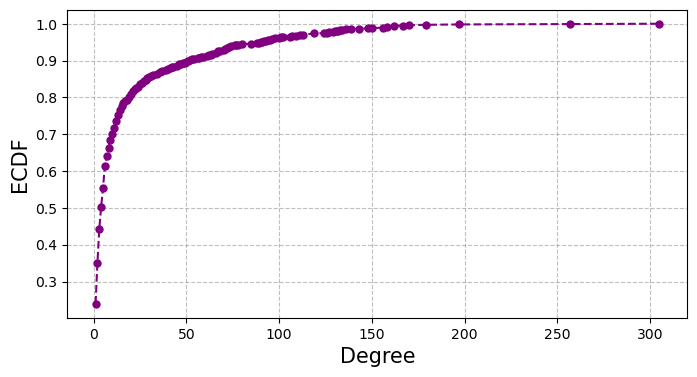

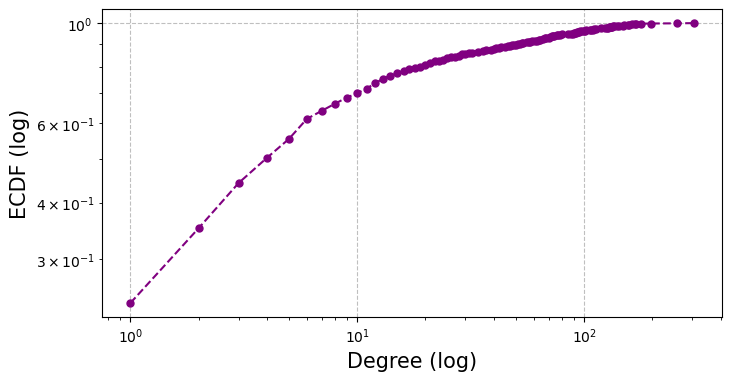

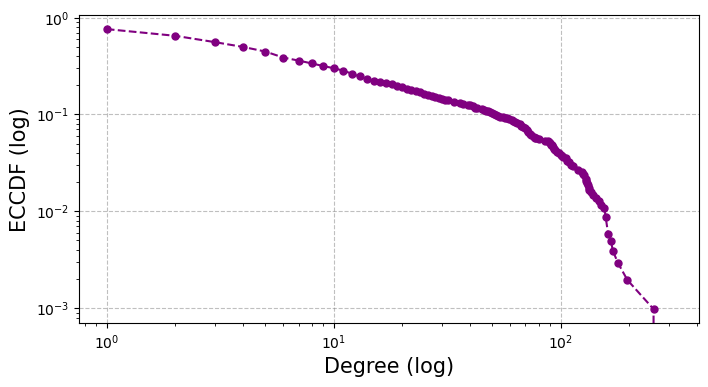

In [1205]:
# ECDF in linear scale
cdf_function = ECDF(L_degree)
x = np.unique(L_degree)
y = cdf_function(x)

fig_cdf_function = plt.figure(figsize=(8, 4)) 
axes = fig_cdf_function.gca()

axes.plot(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree', size=15)
axes.set_ylabel('ECDF', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

# ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8, 4))
axes = fig_cdf_function.gca()

axes.loglog(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree (log)', size=15)
axes.set_ylabel('ECDF (log)', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

# ECCDF in loglog scale
y = 1 - cdf_function(x)

fig_ccdf_function = plt.figure(figsize=(8, 4))
axes = fig_ccdf_function.gca()

axes.loglog(x, y, color='purple', linestyle='--', marker='o', ms=5)
axes.set_xlabel('Degree (log)', size=15)
axes.set_ylabel('ECCDF (log)', size=15)
axes.grid(True, which='major', linestyle='--', color='grey', alpha=.5)

## Erdös-Renyi MODEL

In [1206]:
p=L_density

In [1207]:
rn = nx.fast_gnp_random_graph(L.order(),p)

In [1208]:
print('Number of nodes: {} - Number of links: {}'.format(rn.order(),rn.size()))

Number of nodes: 1022 - Number of links: 8539


In [1209]:
rn_degree = list(dict(rn.degree()).values())

In [1210]:
print("Random Graph Degree statistics (Based on  model): ")
print("Mean: " + str(round(np.mean(rn_degree),4)))
print("Median: " + str(np.median(rn_degree))) 
print("Standard deviation: " + str(round(np.std(rn_degree),4)))
print("Maximum: " + str(np.max(rn_degree)))
print("Minimum: " + str(np.min(rn_degree)))

Random Graph Degree statistics (Based on  model): 
Mean: 16.7104
Median: 17.0
Standard deviation: 4.239
Maximum: 29
Minimum: 4


Text(0, 0.5, 'ECCDF (log)')

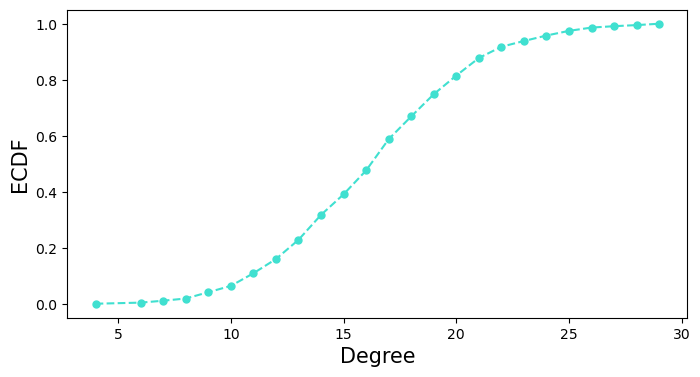

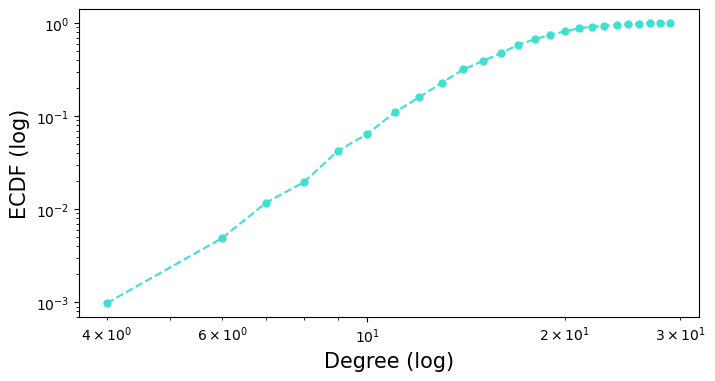

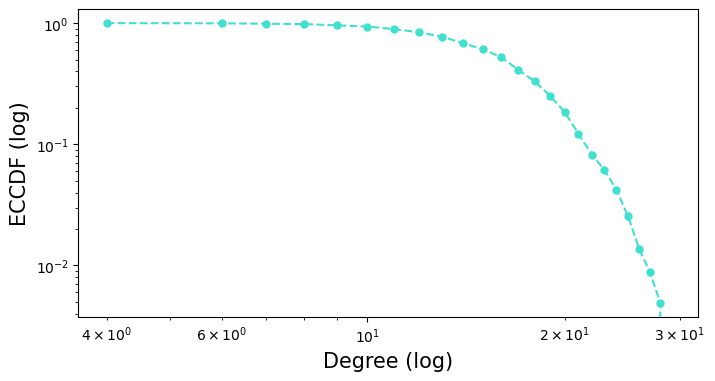

In [1211]:
# ECDF in linear scale
cdf_function = ECDF(rn_degree)
x = np.unique(rn_degree)
y = cdf_function(x)
fig_cdf_function = plt.figure(figsize=(8,4)) 
axes = fig_cdf_function.gca()
axes.plot(x,y,color = 'turquoise', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree',size = 15)
axes.set_ylabel('ECDF',size = 15)

#ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8,4))
axes = fig_cdf_function.gca()
axes.loglog(x,y,color = 'turquoise', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECDF (log)',size = 15)

# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,4))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'turquoise', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECCDF (log)',size = 15)

## Comparing European network (red) and random graph (orange) ECCDFs

Text(0.5, 1.0, 'Comparison of degree distribution between the European Air Network graph and the Random Graph')

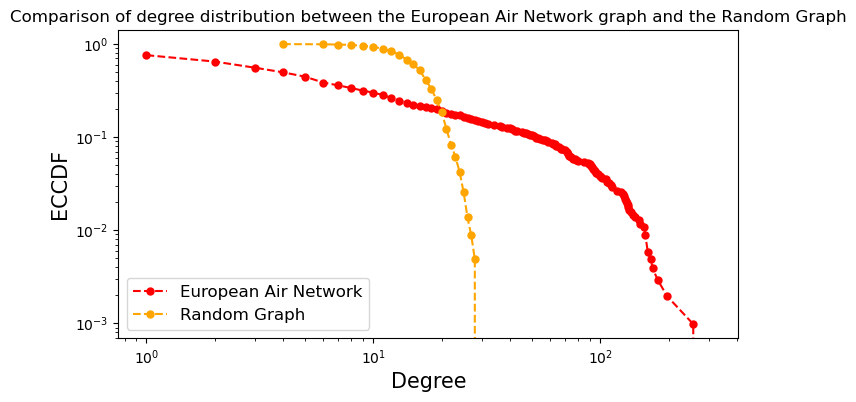

In [1212]:
cdf = ECDF(L_degree)
x = np.unique(L_degree)
y = cdf(x)

cdf_rn = ECDF(rn_degree)
x_rn = np.unique(rn_degree)
y_rn = cdf_rn(x_rn)

fig_cdf_twitch = plt.figure(figsize=(8,4))
axes = fig_cdf_twitch.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=5, color='red', linestyle='--', label='European Air Network')
axes.loglog(x_rn,1-y_rn,marker='o',ms=5, color='orange', linestyle='--', label='Random Graph')

axes.set_xlabel('Degree',size=15)
axes.set_ylabel('ECCDF', size = 15)

axes.legend(loc='lower left', fontsize=12)
axes.set_title('Comparison of degree distribution between the European Air Network graph and the Random Graph')

In [1221]:
percentile_99 = np.percentile(L_degree,99)
print(percentile_99)

157.57999999999993


In [1222]:
#HUBS 

hub = [k for k,v in dict(L.degree()).items() if v>= percentile_99]
print('Number of hubs:',len(hub))
print('List of hubs:', list(hub))

print('Number of isolated nodes:', list(nx.isolates(F)))

Number of hubs: 11
List of hubs: [1218, 599, 1555, 340, 13696, 1229, 346, 1524, 548, 1613, 1678]
Number of isolated nodes: []


In [1223]:
df_hubs = dflights_j[dflights_j['Airport ID_x'].isin(hub)]['departure_iataCode'].unique()
print(df_hubs)
                            

['BCN' 'DUB' 'FCO' 'FRA' 'IST' 'MAD' 'MUC' 'MXP' 'STN' 'VIE' 'ZRH']


In [1266]:
# Define a function to categorize airlines
def categorize_airline(airline):
    airline_lower = airline.lower()
    if airline_lower in low_cost_companies:
        return 'low-cost'
    elif airline_lower in star_alliance:
        return 'star alliance'
    elif airline_lower in sky_team:
        return 'sky team'
    elif airline_lower in one_world:
        return 'one world'
    elif airline_lower in charter:
        return 'charter'
    else:
        return 'other'
    

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


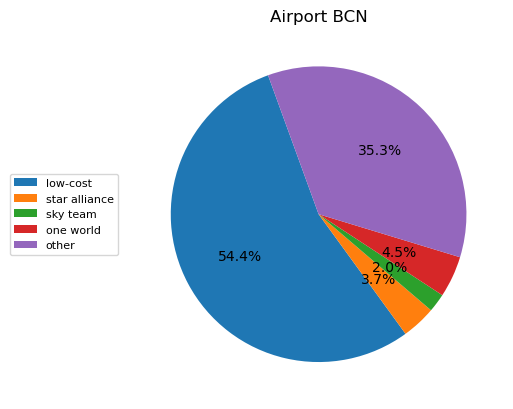

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


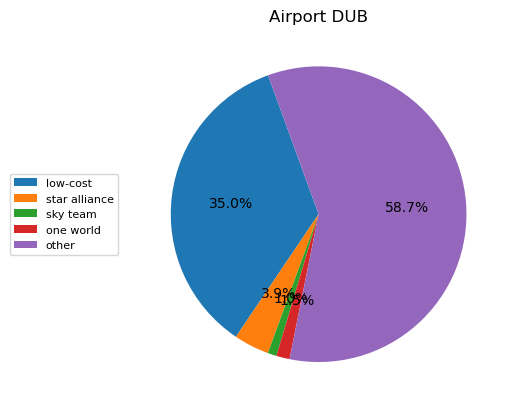

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


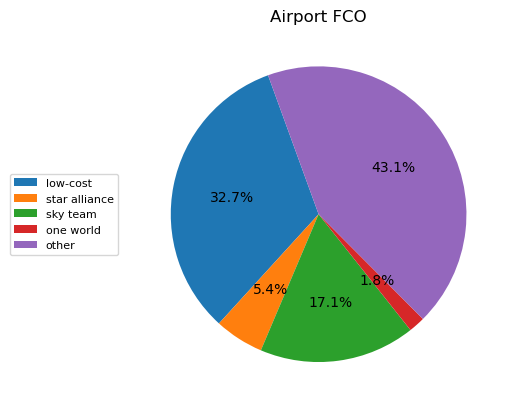

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


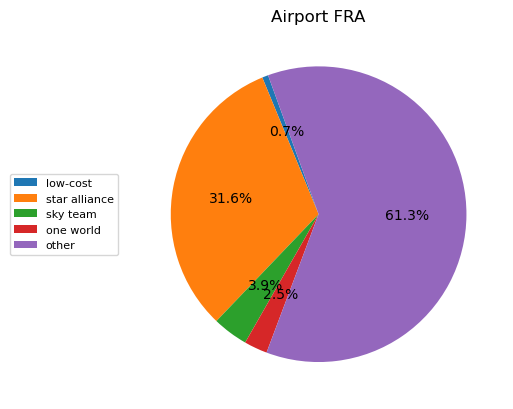

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


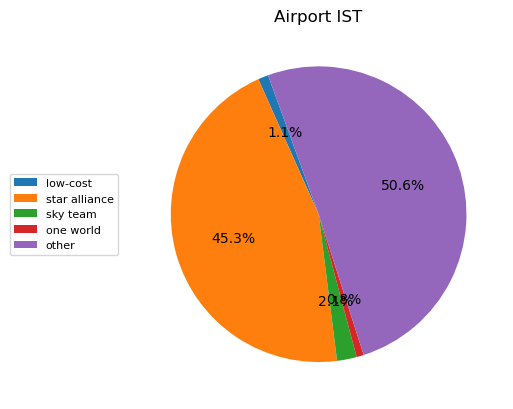

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


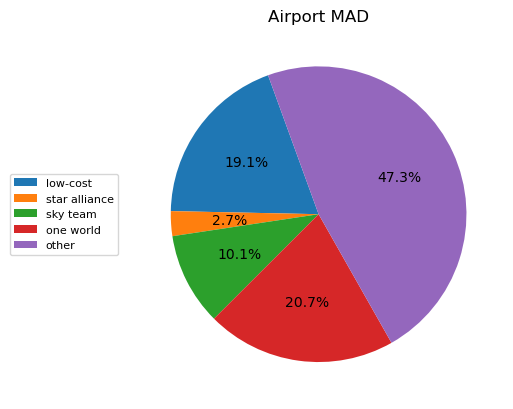

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


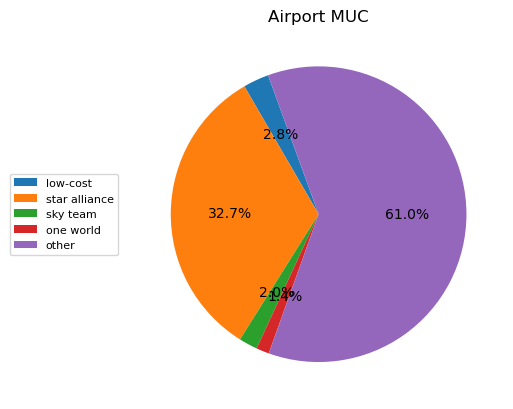

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


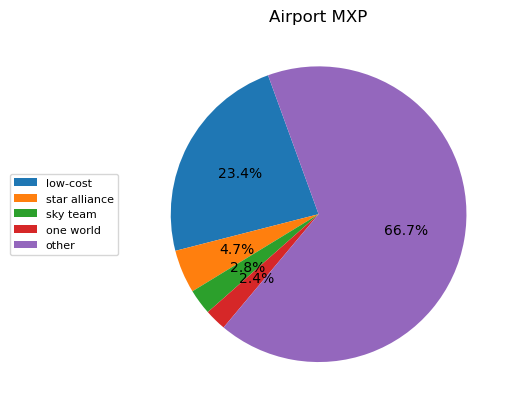

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


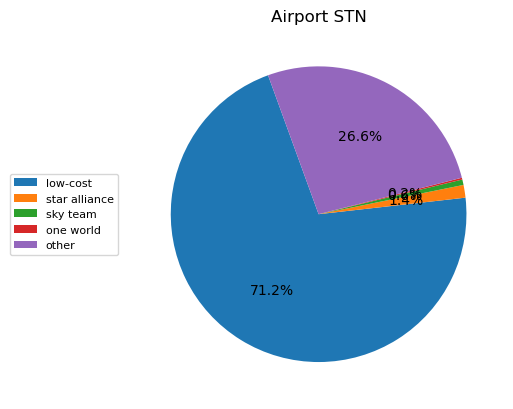

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


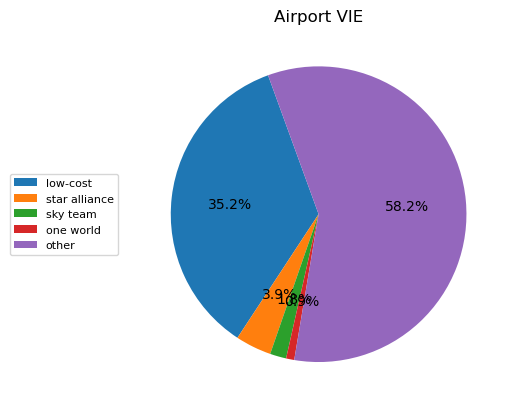

/var/folders/y3/fp6whjf1393cvd0zgc73f0qm0000gn/T/ipykernel_20649/3653181150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)


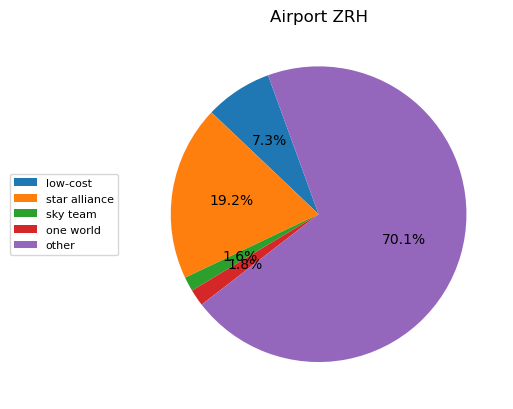

In [1310]:
# Create pie charts for each airport
for airport in df_hubs:
    # Filter the data for the current airport
    airport_pie = new_df[(new_df['departure_iataCode'] == airport) | (new_df['arrival_iataCode'] == airport)]
    
    # Categorize the airlines
    airport_pie['airline_category'] = airport_pie['airline_name'].apply(categorize_airline)
    
    # Count the number of flights for each airline category
    airline_counts = airport_pie['airline_category'].value_counts()
    
    # Categorize airlines that are not in the lists as 'other'
    airline_counts['other'] = airline_counts.get('other', 0) + airline_counts[~airline_counts.index.isin(['low-cost', 'star alliance', 'sky team', 'one world','charter'])].sum()
    airline_counts = airline_counts[['low-cost', 'star alliance', 'sky team', 'one world', 'other']]
    
    # Plot the pie chart
    fig, ax = plt.subplots()
    ax.pie(airline_counts, autopct='%1.1f%%', startangle=110
          )
    ax.set_title(f'Airport {airport}')
    ax.legend(airline_counts.index, loc='center left', bbox_to_anchor=(-0.35, .5), fontsize=8)
    # adjust the label positions
    #plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)
    plt.show()
    

In [ ]:
print(nx.is_connected(L))
print(nx.number_connected_components(L))

In [1196]:
components = nx.connected_components(L)
for i, component in enumerate(components):
    print(f"Airports in connected component {i+1}:")
    for airport in component:
        print(airport)
    print()

Airports in connected component 1:
2050
6146
6147
6149
6150
6148
8
9
10
11
2057
4105
6152
4108
16
12
6153
2064
18
6160
6165
4119
2072
6161
2074
6162
6166
6164
2082
4130
2090
4161
4162
13
4166
70
4167
2121
8266
15
2131
4190
4191
4192
4193
4194
4195
4196
4197
4198
2157
2162
2170
2172
125
2176
2177
2179
2180
2188
2190
2191
146
2194
2195
2202
156
4252
2206
2207
178
4274
2234
2236
8381
193
2241
4297
4111
209
210
4309
4313
4315
220
4317
8414
221
4316
4322
6151
2276
4325
230
231
2279
4328
4330
234
235
238
4331
4327
6154
244
245
246
6390
248
4345
6392
253
6156
4350
4352
4353
6157
4355
260
4357
6158
4362
4363
4364
4365
6159
4367
4368
273
4369
4371
4372
4373
4374
4375
280
4379
286
287
8482
293
295
298
299
302
304
308
309
310
2359
6464
6466
6467
8208
338
339
340
341
342
6485
344
345
346
347
348
349
350
6493
352
353
354
355
356
6492
2397
361
362
364
370
371
373
374
378
382
399
400
410
412
413
415
416
417
421
8613
428
429
430
432
433
435
437
438
439
441
442
446
448
453
458
460
462
465
467
468
469
4

In [875]:
L_triangles_list = list(nx.triangles(L).values())

In [876]:
# get the number of triangles for each node
triangles = nx.triangles(L)

# print the number of triangles for each node
for node, num_triangles in triangles.items():
    print(f"Node {node} is part of {num_triangles} triangles.")
    
    

Node 628 is part of 52 triangles.
Node 1230 is part of 2557 triangles.
Node 607 is part of 35 triangles.
Node 1212 is part of 1605 triangles.
Node 299 is part of 13 triangles.
Node 737 is part of 2107 triangles.
Node 1218 is part of 3283 triangles.
Node 1739 is part of 1005 triangles.
Node 465 is part of 258 triangles.
Node 636 is part of 301 triangles.
Node 1525 is part of 2164 triangles.
Node 469 is part of 1379 triangles.
Node 1216 is part of 245 triangles.
Node 608 is part of 1195 triangles.
Node 1538 is part of 1695 triangles.
Node 738 is part of 75 triangles.
Node 1264 is part of 968 triangles.
Node 494 is part of 116 triangles.
Node 490 is part of 1141 triangles.
Node 302 is part of 2325 triangles.
Node 1423 is part of 1352 triangles.
Node 1489 is part of 2563 triangles.
Node 1367 is part of 763 triangles.
Node 1622 is part of 29 triangles.
Node 344 is part of 2116 triangles.
Node 1652 is part of 501 triangles.
Node 609 is part of 2823 triangles.
Node 304 is part of 1233 triangl

In [1343]:
transitivity = nx.transitivity(L)
print(transitivity)

0.27514590256648247


transitivity is a measure of the extent to which triangles or triplets in a network are closed. It is defined as the ratio of the number of triangles in a network to the number of connected triples (i.e., the number of triplets that have at least two connected edges). A higher transitivity indicates a higher tendency for nodes to be connected in clusters, which can reflect the presence of cohesive groups or communities within the network.

In [1386]:
print('g - average local clustering: {}'.format(nx.average_clustering(L)))

g - average local clustering: 0.45866981192749984


Average local clustering, also known as average clustering coefficient, is a measure of the level of connectivity or clustering among the immediate neighbors of a node in a network. Specifically, it is the average of the local clustering coefficients of all the nodes in the network, where the local clustering coefficient of a node is the ratio of the number of triangles in which the node is a participant to the number of triplets in which the node participates. The average local clustering coefficient is often used as a summary statistic to characterize the overall level of clustering in a network. It is a value between 0 and 1, where a higher value indicates a higher degree of clustering or connectivity among neighboring nodes.

In [1199]:
print("Local Clustering Coefficient statistics (L): ")
print('European Network - mean local clustering: {}'.format(np.mean(list(nx.clustering(L).values()))))
print('European Network  - standard deviation local clustering: {}'.format(np.std(list(nx.clustering(L).values()))))
print('European Network  - median local clustering: {}'.format(np.median(list(nx.clustering(L).values()))))
print('European Network  - max local clustering: {}'.format(np.max(list(nx.clustering(L).values()))))
print('European Network  - min local clustering: {}'.format(np.min(list(nx.clustering(L).values()))))

Local Clustering Coefficient statistics (L): 
European Network - mean local clustering: 0.4586698119274998
European Network  - standard deviation local clustering: 0.3591520581370066
European Network  - median local clustering: 0.464145987033311
European Network  - max local clustering: 1.0
European Network  - min local clustering: 0.0


In [1200]:
local_clustering_L = list(nx.clustering(L).values())

Text(0, 0.5, 'ECCDF (log)')

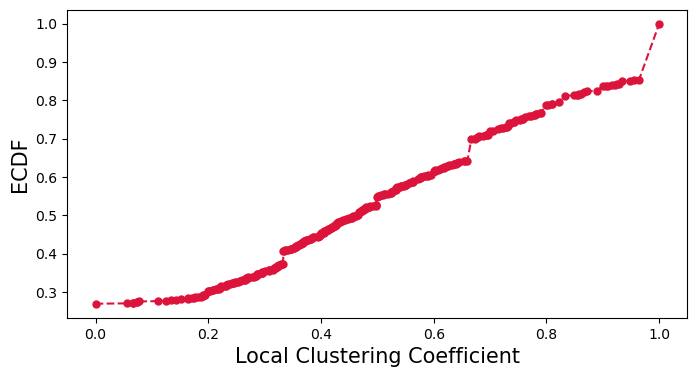

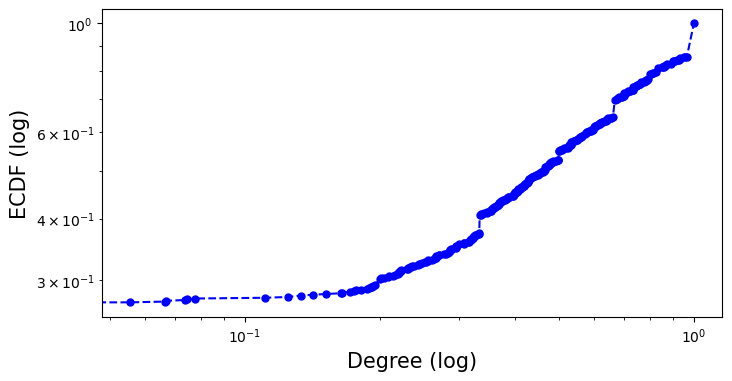

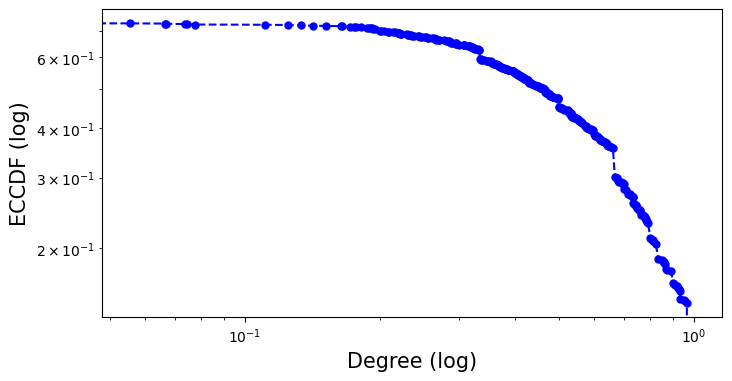

In [1201]:
# ECDF in linear scale
cdf_function = ECDF(local_clustering_L)
x = np.unique(local_clustering_L)
y = cdf_function(x)
fig_cdf_function = plt.figure(figsize=(8,4)) 
axes = fig_cdf_function.gca()
axes.plot(x,y,color = 'crimson', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Local Clustering Coefficient',size = 15)
axes.set_ylabel('ECDF',size = 15)

#ECDF in loglog scale
fig_cdf_function = plt.figure(figsize=(8,4))
axes = fig_cdf_function.gca()
axes.loglog(x,y,color = 'blue', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECDF (log)',size = 15)

# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,4))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'blue', linestyle = '--', marker= 'o',ms = 5)
axes.set_xlabel('Degree (log)',size = 15)
axes.set_ylabel('ECCDF (log)',size = 15)

In [1235]:
print("Pearson coefficient and p-value between Degree and Clustering coefficient: ")
print(scipy.stats.pearsonr(L_degree, local_clustering_L))

Pearson coefficient and p-value between Degree and Clustering coefficient: 
PearsonRResult(statistic=-0.1059839432724968, pvalue=0.0006898337056300955)


In [1294]:
degree_centrality = nx.degree_centrality(L)
betweenness_centrality = nx.betweenness_centrality(L)
eigenvector_centrality = nx.eigenvector_centrality(L)

hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_betweenness = sorted(betweenness_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]

print('degree:      ',hub_degree)
print('pagerank: ',hub_betweenness)
print('eigenvector: ',hub_eigenvector)


degree:       (13696, 0.29872673849167486)
pagerank:  (13696, 0.187709892854427)
eigenvector:  (340, 0.15739484262884748)


In [1295]:
print("Pearson coefficient and p-value between Degree and Betweenness Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(betweenness_centrality.values())))
print("Pearson coefficient and p-value between Degree and Eigenvector Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(eigenvector_centrality.values())))
print("Pearson coefficient and p-value between Betweenness  and Eigenvector Centralities: ")
print(scipy.stats.pearsonr(list(betweenness_centrality.values()),list(eigenvector_centrality.values())))



Pearson coefficient and p-value between Degree and Betweenness Centralities: 
PearsonRResult(statistic=0.7503056588823569, pvalue=1.5434423909762147e-185)
Pearson coefficient and p-value between Degree and Eigenvector Centralities: 
PearsonRResult(statistic=0.9517770277675761, pvalue=0.0)
Pearson coefficient and p-value between Betweenness  and Eigenvector Centralities: 
PearsonRResult(statistic=0.5678706745408117, pvalue=2.591934392651498e-88)


In [1296]:
print("Spearman and Kendall coefficient between Degree and Betweenness Centralities: ")
print(scipy.stats.kendalltau(list(degree_centrality.values()),list(betweenness_centrality.values())))


print("Spearman and Kendall coefficient between Degree and Eigenvector Centralities: ")
print(scipy.stats.spearmanr(list(degree_centrality.values()),list(eigenvector_centrality.values())))

print("Spearman and Kendall coefficient between Eigenvector and Betweenness Centralities: ")
print(scipy.stats.kendalltau(list(eigenvector_centrality.values()),list(betweenness_centrality.values())))

Spearman and Kendall coefficient between Degree and Betweenness Centralities: 
KendalltauResult(correlation=0.7814916327870961, pvalue=4.356745286416382e-256)
Spearman and Kendall coefficient between Degree and Eigenvector Centralities: 
SpearmanrResult(correlation=0.8697506508173981, pvalue=4.01071794e-315)
Spearman and Kendall coefficient between Eigenvector and Betweenness Centralities: 
KendalltauResult(correlation=0.5808325004247712, pvalue=1.3034467201013466e-153)


In [1239]:
#ASSORTATIVITY - STUDY WHEN CONNECT ADDITIONAL ATTRIBUTES

In [1324]:
print("Degree assortativity: " + str(nx.degree_assortativity_coefficient(L)))

Degree assortativity: -0.2447805396481949


In [1325]:
#COMMUNITY DETECTION

In [1370]:
seed = 60
partition_library = community_louvain.best_partition(L)

In [1372]:
print(set(partition_library.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [1373]:
nx.set_node_attributes(L, partition_library, "community_library")

In [1374]:
comms = set(partition_library.values())

In [1375]:
list_community_sets_library = [ set() for i in range(len(comms)) ]

In [1387]:
for n, comm in partition_library.items():
    list_community_sets_library[comm].add(n)

In [1388]:
#print("Coverage")
print("Coverage", nx_comm.coverage(L, list_community_sets_library))
#print("Modularity")
print("Modularity", nx_comm.modularity(L, list_community_sets_library, weight='weight'))
#print("Performance")
#print("Performance", nx_comm.performance(G, my_list))

Coverage 0.5203478260869565
Modularity 0.3142348097051106


Coverage is a measure of how well a given set of communities covers the nodes in a network. It is defined as the fraction of nodes that are assigned to at least one community. A higher coverage means that the communities are able to capture a larger fraction of the nodes in the network.

Modularity, on the other hand, measures the quality of a given partition of a network into communities. It is defined as the difference between the fraction of edges within communities and the expected fraction of edges within communities if the edges were distributed at random. A higher modularity means that the communities are more tightly connected with each other than expected by chance, indicating a stronger community structure in the network.

In [1389]:
pairs = []
for i, nodes in enumerate(list_community_sets_library):
    print(i,len(nodes))
    comm_size = (i,len(nodes))
    pairs.append(comm_size)

0 348
1 117
2 186
3 173
4 40
5 2
6 152
7 2
8 2


In [1390]:
community_index = []
number_of_nodes = []

for comm, n_nodes in pairs:
    community_index.append(str(comm))
    number_of_nodes.append(n_nodes) 

Text(0, 0.5, 'Number of nodes')

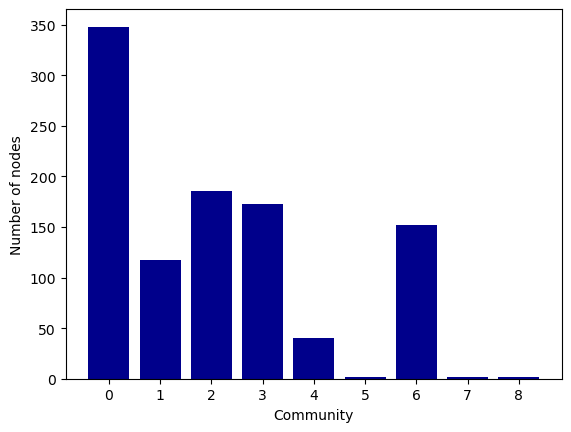

In [1391]:
plt.bar(community_index,number_of_nodes, color='darkblue')
plt.xlabel("Community")
plt.ylabel("Number of nodes")



Centrality in communities


In [1392]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)

In [1393]:
centr_comm = {}
# node -> centrality in the community subgraph

In [1394]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)
    subgraph.order()
    nx.degree_centrality(subgraph)
    
    node_degrees  = nx.degree_centrality(subgraph)
    for n,d in node_degrees.items():
        centr_comm[n] = d

In [1395]:
nx.set_node_attributes(L, centr_comm, "centr_comm")

In [1396]:
nx.has_bridges(L)

True

In [1397]:
nx.write_gexf(L, "graph2023_new.gexf")

In [905]:
bridges = list(nx.bridges(L))
print("List of bridges:", bridges)

List of bridges: [(1230, 7489), (737, 719), (737, 721), (737, 2895), (737, 714), (737, 5594), (1218, 6756), (1218, 1238), (1739, 3368), (1525, 441), (738, 703), (1264, 1425), (1264, 1300), (1264, 1063), (494, 3385), (302, 1120), (302, 3462), (1622, 1643), (1622, 1635), (609, 618), (609, 9), (609, 10), (599, 5577), (585, 3775), (523, 516), (340, 3673), (340, 2978), (340, 2545), (340, 3645), (340, 2882), (340, 1910), (340, 3992), (340, 3570), (340, 3678), (340, 2916), (340, 4105), (340, 178), (534, 5575), (534, 5563), (687, 739), (1665, 125), (421, 430), (421, 433), (421, 448), (421, 416), (355, 3594), (13696, 5801), (13696, 9273), (13696, 6783), (13696, 3967), (13696, 1177), (13696, 3940), (13696, 2121), (13696, 13760), (13696, 4119), (13696, 1173), (13696, 9045), (13696, 2207), (13696, 5687), (13696, 4331), (13696, 2397), (13696, 1094), (13696, 2157), (13696, 918), (13696, 5795), (3956, 1676), (502, 1779), (502, 1881), (502, 2894), (1529, 1754), (1529, 1503), (1638, 2526), (1638, 2531)

In [906]:
df_bridges = dflights_j[dflights_j[['Airport ID_x', 'Airport ID_y']].apply(tuple, axis=1).isin(bridges)]
df_bridges.tail(20)
                            

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
19332,1273,TLS,NCY,Toulouse-Blagnac Airport,Toulouse,France,43.629101,1.363820,luxwing,1,1339,Annecy-Haute-Savoie-Mont Blanc Airport,Annecy,France,45.930833,6.106389,1521
19333,1273,TLS,XFW,Toulouse-Blagnac Airport,Toulouse,France,43.629101,1.363820,star air,8,362,Hamburg-Finkenwerder Airport,Hamburg,Germany,53.535278,9.835556,23
19334,1515,TPS,GKE,Vincenzo Florio Airport Trapani-Birgi,Trapani,Italy,37.911400,12.488000,copenhagen airtaxi,1,769,Geilenkirchen Air Base,Geilenkirchen,Germany,50.960800,6.042420,296
19335,1526,TRN,SXM,Turin Airport,Torino,Italy,45.200802,7.649630,vistajet,1,2899,Princess Juliana International Airport,Philipsburg,Netherlands Antilles,18.041000,-63.108898,13
19336,1613,VIE,FNB,Vienna International Airport,Vienna,Austria,48.110298,16.569700,pink sparrow,1,11785,Neubrandenburg Airport,Neubrandenburg,Germany,53.602200,13.306000,228
19337,1613,VIE,RLG,Vienna International Airport,Vienna,Austria,48.110298,16.569700,pink sparrow,1,772,Rostock-Laage Airport,Laage,Germany,53.918201,12.278300,138
19338,2988,VKO,DAM,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,syrian air,1,2236,Damascus International Airport,Damascus,Syria,33.411499,36.515598,2020
19339,2988,VKO,KGP,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,utair aviation,3,4373,Kogalym International Airport,Kogalym,Russia,62.190399,74.533798,220
19340,2988,VKO,LWN,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,pobeda,5,3965,Gyumri Shirak Airport,Gyumri,Armenia,40.750401,43.859299,5000
19341,2988,VKO,NAJ,Vnukovo International Airport,Moscow,Russia,55.591499,37.261501,utair aviation,1,6090,Nakhchivan Airport,Nakhchivan,Azerbaijan,39.188801,45.458401,2863


In [907]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in dflights_j.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in dflights_j.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    
    L.add_edge(origin, destination, weight= cnts, airline_name =airline_name )
    
# set bridge attribute to True for corresponding edges
for u, v in bridges:
    L[u][v]['bridge'] = True

# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "bridges_graph2023_new.gexf")

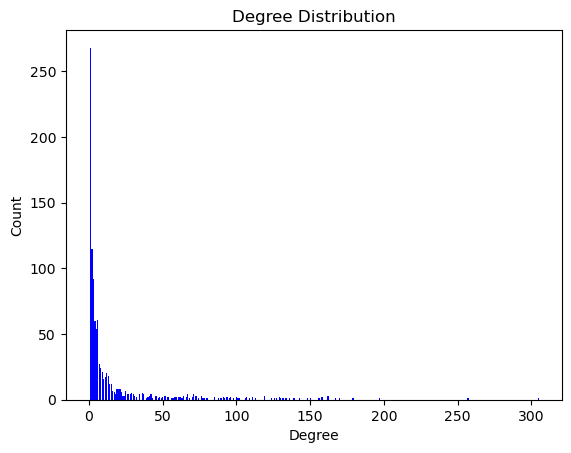

In [909]:
degree_sequence = sorted([d for n, d in L.degree()], reverse=True)
degree_count = nx.degree_histogram(L)
plt.bar(range(len(degree_count)), degree_count, width=0.8, color='b')
plt.title('Degree Distribution')
plt.ylabel('Count')
plt.xlabel('Degree')
plt.show()